## In this notebook we will use transfer learning in order to classify wich image contain benign or malign melanoma using efficientnet from google

In [1]:
!pip install -q efficientnet_pytorch

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# System
import cv2
import os, os.path
from PIL import Image              # from RBG to YCbCr
import gc
import time
import datetime

# Basics
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# %matplotlib inline
from tqdm.notebook import tqdm      # beautiful progression bar

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate)
from albumentations.pytorch import ToTensorV2, ToTensor

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50
import missingno as msno 

import warnings
warnings.filterwarnings("ignore")

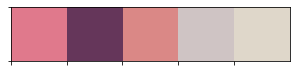

In [3]:
# Set Color Palettes for the notebook
colors_nude = ['#e0798c','#65365a','#da8886','#cfc4c4','#dfd7ca']
sns.palplot(sns.color_palette(colors_nude))

In [4]:
# Directory
directory = '../input/siim-isic-melanoma-classification'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train.csv')
test_df = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df), len(test_df)))

# Change columns names
new_names = ['dcm_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

Train has 33,126 rows and Test has 10,982 rows.


# FILL NA

## Visualise NA values

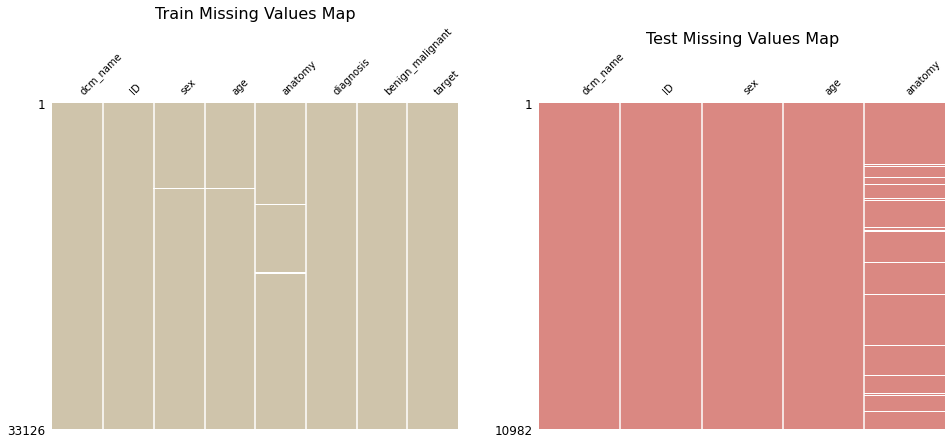

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

msno.matrix(train_df, ax = ax1, color=(207/255, 196/255, 171/255), fontsize=10)
msno.matrix(test_df, ax = ax2, color=(218/255, 136/255, 130/255), fontsize=10)

ax1.set_title('Train Missing Values Map', fontsize = 16)
ax2.set_title('Test Missing Values Map', fontsize = 16);


## We have missing value in sex, age and anatomy  

In [6]:
# Check how many are males and how many females
anatomy = ['lower extremity', 'upper extremity', 'torso']
print(train_df[(train_df['anatomy'].isin(anatomy)) & (train_df['target'] == 0)]['sex'].value_counts())

# Impute the missing values with male
train_df['sex'].fillna("male", inplace = True) 

male      15173
female    14523
Name: sex, dtype: int64


In [7]:
# Check the mean age
anatomy = ['lower extremity', 'upper extremity', 'torso']
median = train_df[(train_df['anatomy'].isin(anatomy)) & (train_df['target'] == 0) & (train_df['sex'] == 'male')]['age'].median()
print('Median is:', median)

# Impute the missing values with the median
train_df['age'].fillna(median, inplace = True) 

Median is: 50.0


In [8]:
median = test_df[test_df['anatomy'].isnull()]['age'].median()
print('Median age for NA anatomy  :', median)

# Select most frequent anatomy for age 70 (median)
value = test_df[test_df['age'] == median]['anatomy'].value_counts().reset_index()['index'][0]
print('value is:', value)

# Impute the value
test_df['anatomy'].fillna(value, inplace = True) 

# Impute for anatomy
train_df['anatomy'].fillna(value, inplace = True) 

Median age for NA anatomy  : 70.0
value is: torso


# Data imbalance

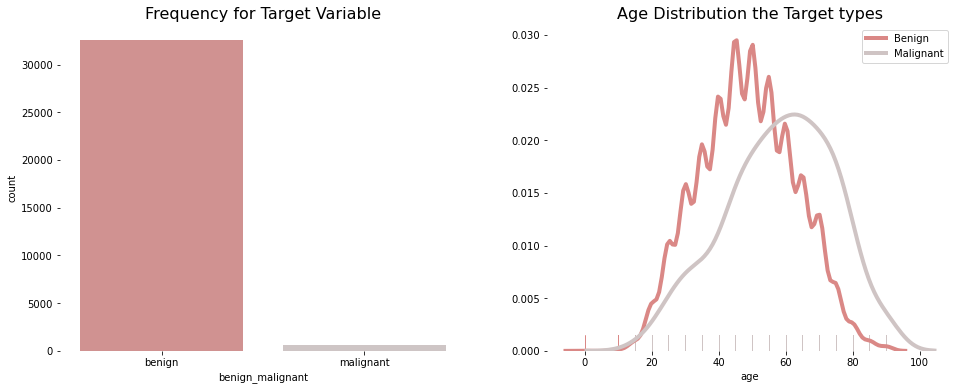

In [9]:
# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(data = train_df, x = 'benign_malignant', palette=colors_nude[2:4],
                 ax=ax1)
b = sns.distplot(a = train_df[train_df['target']==0]['age'], ax=ax2, color=colors_nude[2], 
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Benign')
c = sns.distplot(a = train_df[train_df['target']==1]['age'], ax=ax2, color=colors_nude[3], 
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Malignant')

ax1.set_title('Frequency for Target Variable', fontsize=16)
ax2.set_title('Age Distribution the Target types', fontsize=16)
sns.despine(left=True, bottom=True);

### Very HIGH class imbalance, not good for modeling.
### Benign case follows a normal distribution while the peak of malign case is a bit oriented towards higher age values.


### Encode categorical data in numerical form (OHE)

In [10]:
# === TRAIN ===
to_encode = ['sex', 'anatomy', 'diagnosis']
encoded_all = []

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(train_df[column])
    encoded_all.append(encoded)
    
train_df['sex'] = encoded_all[0]
train_df['anatomy'] = encoded_all[1]
train_df['diagnosis'] = encoded_all[2]

if 'benign_malignant' in train_df.columns : train_df.drop(['benign_malignant'], axis=1, inplace=True)

In [11]:
# === TEST ===
to_encode = ['sex', 'anatomy']
encoded_all = []

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(test_df[column])
    encoded_all.append(encoded)
    
test_df['sex'] = encoded_all[0]
test_df['anatomy'] = encoded_all[1]

In [12]:
# Save the files
train_df.to_csv('train_clean.csv', index=False)
test_df.to_csv('test_clean.csv', index=False)

### We will use supplementary data to fill this imbalance gap, from [melanoma external malignant 256](https://www.kaggle.com/nroman/melanoma-external-malignant-256)
#### So let's concatenate those datasets !

In [13]:
# My Train: with imputed missing values + OHE
my_train = pd.read_csv('../input/train_clean.csv')

# Drop path columns and Diagnosis (it won't be available during TEST)
# We'll rewrite them once the data is concatenated
to_drop = ['path_dicom','path_jpeg', 'diagnosis']
for drop in to_drop:
    if drop in my_train.columns :
        my_train.drop([drop], axis=1, inplace=True)

# Roman's Train (external dataset): with added data for Malignant category
roman_train = pd.read_csv('../input/../input/melanoma-external-malignant-256/train_concat.csv')


# preprocess roman_train
roman_train['patient_id'] = roman_train['patient_id'].fillna(0)

# Encode data in numerical form (OHE)
to_encode = ['sex', 'anatom_site_general_challenge']
encoded_all = []

roman_train[to_encode[0]] = roman_train[to_encode[0]].astype(str)
roman_train[to_encode[1]] = roman_train[to_encode[1]].astype(str)

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(roman_train[column])
    encoded_all.append(encoded)
    
roman_train[to_encode[0]] = encoded_all[0]
roman_train[to_encode[1]] = encoded_all[1]

# Give all columns the same name
roman_train.columns = my_train.columns


# --- Concatenate info which is not available in my_train ---
common_images = my_train['dcm_name'].unique()
new_data = roman_train[~roman_train['dcm_name'].isin(common_images)]

# Merge all together
train_df = pd.concat([my_train, new_data], axis=0)

# --- Read in Test data (also cleaned, imputed, OHE) ---
test_df = pd.read_csv('../input/test_clean.csv')

# Drop columns
for drop in to_drop:
    if drop in test_df.columns :
        test_df.drop([drop], axis=1, inplace=True)

# Create path column to image folder for both Train and Test
path_train = '../input/melanoma-external-malignant-256/train/train/'
path_test = '../input/melanoma-external-malignant-256/test/test/'

train_df['path_jpg'] = path_train + train_df['dcm_name'] + '.jpg'
test_df['path_jpg'] = path_test + test_df['dcm_name'] + '.jpg'



# NORMALIZE 
train_df['age'] = train_df['age'].fillna(-1)

normalized_train = preprocessing.normalize(train_df[['sex', 'age', 'anatomy']])
normalized_test = preprocessing.normalize(test_df[['sex', 'age', 'anatomy']])

train_df['sex'] = normalized_train[:, 0]
train_df['age'] = normalized_train[:, 1]
train_df['anatomy'] = normalized_train[:, 2]

test_df['sex'] = normalized_test[:, 0]
test_df['age'] = normalized_test[:, 1]
test_df['anatomy'] = normalized_test[:, 2]

# Save the files
train_df.to_csv('train_full_clean.csv', index=False)
test_df.to_csv('test_full_clean.csv', index=False)

Text(0.5, 1.0, 'Frequency for Target Variable')

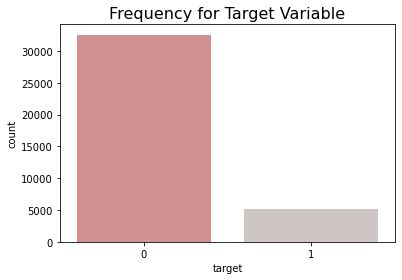

In [14]:
# Figure
sns.countplot(data = train_df, x = 'target', palette=colors_nude[2:4])
plt.title('Frequency for Target Variable', fontsize=16)

### Much better to train our neural netwwork

In [15]:
# STATICS
vertical_flip = 0.5
horizontal_flip = 0.5

csv_columns = ['sex', 'age', 'anatomy']
no_columns = 3
output_size = 1


In [16]:
class MelanomaDataset(Dataset):
    
    def __init__(self, dataframe, vertical_flip, horizontal_flip,
                 is_train=True, is_valid=False, is_test=False):
        self.dataframe, self.is_train, self.is_valid = dataframe, is_train, is_valid
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        
        if is_train or is_test:
            self.transform = Compose([RandomResizedCrop(height=224, width=224, scale=(0.4, 1.0)),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit = [0.8, 1.2]),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      HueSaturationValue(sat_shift_limit=[0.7, 1.3], 
                                                         hue_shift_limit=[-0.1, 0.1]),
                                      RandomBrightnessContrast(brightness_limit=[0.7, 1.3],
                                                               contrast_limit= [0.7, 1.3]),
                                      Normalize(),
                                      ToTensor()])
        else:
            self.transform = Compose([Normalize(),
                                      ToTensor()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        image_path = self.dataframe['path_jpg'][index]
        image = cv2.imread(image_path)
        # For this image also import .csv information (sex, age, anatomy)
        csv_data = np.array(self.dataframe.iloc[index][['sex', 'age', 'anatomy']].values, 
                            dtype=np.float32)
        
        # Apply transforms
        image = self.transform(image=image)
        image = image['image']
        
        if self.is_train or self.is_valid:
            return (image, csv_data), self.dataframe['target'][index]
        else:
            return (image, csv_data)

## EfficientNet

> There are multiple EffNet Architectures that can be used, but at the expense of computing more and more parameters.
<img src='https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s1600/image3.png' width=350>

> So due to infrastructure limitation we will use B2

In [17]:
class EfficientNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns = no_columns
        
        self.features = EfficientNet.from_pretrained('efficientnet-b2')
      
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))

        self.classification = nn.Sequential(nn.Linear(1408 + 250, output_size))

        
    def forward(self, image, csv_data, prints=False):    
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input csv_data shape:', csv_data.shape)
        
        # IMAGE CNN
        image = self.features.extract_features(image)
        if prints: print('Features Image shape:', image.shape)
        image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        if prints: print('Image Reshaped shape:', image.shape)
            
        # CSV FNN
        csv_data = self.csv(csv_data)
        if prints: print('CSV Data:', csv_data.shape)
            
        # Concatenate
        image_csv_data = torch.cat((image, csv_data), dim=1)
        
        # CLASSIF
        out = self.classification(image_csv_data)
        if prints: print('Out shape:', out.shape)
        
        return out

# Training

In [18]:
train_len = len(train_df)
test_len = len(test_df)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# prepare Out of Fold Predictions (out of fold)
oof = np.zeros(shape = (train_len, 1))

# Predictions
preds_submission = torch.zeros(size = (test_len, 1), dtype=torch.float32, device=device)


print('oof shape:', oof.shape, '\n' +
      'predictions shape:', preds_submission.shape)

oof shape: (37648, 1) 
predictions shape: torch.Size([10982, 1])


In [19]:
k = 6              # number of folds in Group K Fold

In [20]:
group_fold = GroupKFold(n_splits = k)

# Generate indices to split data into training and test set.
folds = group_fold.split(X = np.zeros(train_len), 
                         y = train_df['target'], 
                         groups = train_df['ID'].tolist())

## Training Loop...

The training loop is inspired by <a href='https://www.kaggle.com/nroman/melanoma-pytorch-starter-efficientnet/output'>Melanoma. Pytorch starter. EfficientNet</a>. 
It help me to understood TTA, how to optimize the learning rate and how to use K Fold in Deep Learning. 

In [21]:
# Hyperparameter
epochs = 15
patience = 3
TTA = 3
num_workers = 8
learning_rate = 0.0005
weight_decay = 0.0
lr_patience = 1            # 1 model not improving until lr is decreasing
lr_factor = 0.4            # by how much the lr is decreasing

batch_size1 = 32
batch_size2 = 16

In [22]:
def train_folds(preds_submission, model, version = 'v1'):
    # Creates a .txt file that will contain the logs
    f = open(f"logs_{version}.txt", "w+")
    
    
    for fold, (train_index, valid_index) in enumerate(folds):
        # Append to .txt
        with open(f"logs_{version}.txt", 'a+') as f:
            print('-'*10, 'Fold:', fold+1, '-'*10, file=f)
        print('-'*10, 'Fold:', fold+1, '-'*10)

        # Best ROC score in this fold
        best_roc = None
        # Reset patience before every fold
        patience_f = patience

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                      patience=lr_patience, verbose=True, factor=lr_factor)
        criterion = nn.BCEWithLogitsLoss()


        # Read in Data
        train_data = train_df.iloc[train_index].reset_index(drop=True)
        valid_data = train_df.iloc[valid_index].reset_index(drop=True)

        # Create Data instances
        train = MelanomaDataset(train_data, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip, 
                                is_train=True, is_valid=False, is_test=False)
        valid = MelanomaDataset(valid_data, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip, 
                                is_train=False, is_valid=True, is_test=False)
        # Read in test data (with same data augmentation as Train data)
        test = MelanomaDataset(test_df, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip,
                               is_train=False, is_valid=False, is_test=True)

        # Dataloaders
        train_loader = DataLoader(train, batch_size=batch_size1, shuffle=True, num_workers=num_workers)

        valid_loader = DataLoader(valid, batch_size=batch_size2, shuffle=False, num_workers=num_workers)
        test_loader = DataLoader(test, batch_size=batch_size2, shuffle=False, num_workers=num_workers)


        # === EPOCHS ===
        for epoch in range(epochs):
            start_time = time.time()
            correct = 0
            train_losses = 0

            # === TRAIN ===
            model.train()

            for (images, csv_data), labels in train_loader:
                images = torch.tensor(images, device=device, dtype=torch.float32)
                csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
                labels = torch.tensor(labels, device=device, dtype=torch.float32)
                optimizer.zero_grad()

                out = model(images, csv_data)
                loss = criterion(out, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()

                train_losses += loss.item()
                train_preds = torch.round(torch.sigmoid(out))
                correct += (train_preds.cpu() == labels.cpu().unsqueeze(1)).sum().item()

            # Compute Train Accuracy
            train_acc = correct / len(train_index)


            # === EVAL ===
            model.eval()

            # Create matrix to store evaluation predictions (for accuracy)
            valid_preds = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)

            with torch.no_grad():
                for k, ((images, csv_data), labels) in enumerate(valid_loader):
                    images = torch.tensor(images, device=device, dtype=torch.float32)
                    csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
                    labels = torch.tensor(labels, device=device, dtype=torch.float32)

                    out = model(images, csv_data)
                    pred = torch.sigmoid(out)
                    valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] = pred

                # Compute Val accuracy
                valid_acc = accuracy_score(valid_data['target'].values, 
                                           torch.round(valid_preds.cpu()))
                # Compute ROC
                valid_roc = roc_auc_score(valid_data['target'].values, 
                                          valid_preds.cpu())

                # Compute time on Train + Eval
                duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]


                # PRINT INFO
                with open(f"logs_{version}.txt", 'a+') as f:
                    print('{} | Epoch: {}/{} | Loss: {:.4} | Train Acc: {:.3} | Valid Acc: {:.3} | ROC: {:.3}'.\
                     format(duration, epoch+1, epochs, train_losses, train_acc, valid_acc, valid_roc), file=f)
                # Print to console
                print('{} | Epoch: {}/{} | Loss: {:.4} | Train Acc: {:.3} | Valid Acc: {:.3} | ROC: {:.3}'.\
                     format(duration, epoch+1, epochs, train_losses, train_acc, valid_acc, valid_roc))


                # === SAVE MODEL ===

                # Update scheduler (for learning_rate)
                scheduler.step(valid_roc)

                # Update best_roc
                if not best_roc: # If best_roc = None
                    best_roc = valid_roc
                    torch.save(model.state_dict(),
                               f"Fold{fold+1}_Epoch{epoch+1}_ValidAcc_{valid_acc:.3f}_ROC_{valid_roc:.3f}.pth")
                    continue

                if valid_roc > best_roc:
                    best_roc = valid_roc
                    # Reset patience (because we have improvement)
                    patience_f = patience
                    torch.save(model.state_dict(),
                               f"Fold{fold+1}_Epoch{epoch+1}_ValidAcc_{valid_acc:.3f}_ROC_{valid_roc:.3f}.pth")
                else:
                    # Decrease patience (no improvement in ROC)
                    patience_f = patience_f - 1
                    if patience_f == 0:
                        with open(f"logs_{version}.txt", 'a+') as f:
                            print('Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                                  format(best_roc), file=f)
                        print('Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                              format(best_roc))
                        break


        # === INFERENCE ===
        # Choose model with best_roc in this fold
        best_model_path = '../working/' + [file for file in os.listdir('../working') if str(round(best_roc, 3)) in file and 'Fold'+str(fold+1) in file][0]
        # Using best model from Epoch Train
        model.load_state_dict(torch.load(best_model_path))
        model.eval()

        with torch.no_grad():
            # --- EVAL ---
            # Predicting again on Validation data to get preds for OOF
            valid_preds = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)

            for k, ((images, csv_data), _) in enumerate(valid_loader):
                images = torch.tensor(images, device=device, dtype=torch.float32)
                csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)

                out = model(images, csv_data)
                pred = torch.sigmoid(out)
                valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] = pred

            # Save info to OOF
            oof[valid_index] = valid_preds.cpu().numpy()


            # --- TEST ---
            # prediction for our TEST data
            for i in range(TTA):
                for k, (images, csv_data) in enumerate(test_loader):
                    images = torch.tensor(images, device=device, dtype=torch.float32)
                    csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)

                    out = model(images, csv_data)
                    # Covert to probablities
                    out = torch.sigmoid(out)

                    # ADD the prediction to the matrix we already created
                    preds_submission[k*images.shape[0] : k*images.shape[0] + images.shape[0]] += out


            # Divide Predictions by TTA (to average the results during TTA)
            preds_submission /= TTA


        # === CLEANING ===
        # Clear memory
        del train, valid, train_loader, valid_loader, images, labels
        # Garbage collector
        gc.collect()

In [23]:
model = EfficientNetwork(output_size = output_size, no_columns=no_columns).to(device)

train_folds(preds_submission = preds_submission, model = model)

# Save OOF values
oof = pd.DataFrame(data = oof, columns=['oof'])
save_oof.to_csv(f'oof.csv', index=False)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
0:04:48 | Epoch: 1/15 | Loss: 257.6 | Train Acc: 0.905 | Valid Acc: 0.931 | ROC: 0.908
0:04:38 | Epoch: 2/15 | Loss: 226.7 | Train Acc: 0.918 | Valid Acc: 0.943 | ROC: 0.971
0:04:41 | Epoch: 3/15 | Loss: 218.0 | Train Acc: 0.923 | Valid Acc: 0.944 | ROC: 0.97
0:04:41 | Epoch: 4/15 | Loss: 214.7 | Train Acc: 0.923 | Valid Acc: 0.934 | ROC: 0.967
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
0:04:40 | Epoch: 5/15 | Loss: 201.2 | Train Acc: 0.929 | Valid Acc: 0.944 | ROC: 0.977
0:04:39 | Epoch: 6/15 | Loss: 197.8 | Train Acc: 0.93 | Valid Acc: 0.941 | ROC: 0.977
0:04:39 | Epoch: 7/15 | Loss: 195.2 | Train Acc: 0.932 | Valid Acc: 0.951 | ROC: 0.976
0:04:40 | Epoch: 8/15 | Loss: 192.0 | Train Acc: 0.933 | Valid Acc: 0.951 | ROC: 0.979
0:04:38 | Epoch: 9/15 | Loss: 192.3 | Train Acc: 0.932 | Valid Acc: 0.952 | ROC: 0.979
0:04:36 | Epoch: 10/15 | Loss: 191.3 | Train Acc: 0.932 | Valid Acc: 0.958 | ROC

## Evaluation

### 1. ROC for OOF

In [34]:
# Import OOF (pretrained)
oof = pd.read_csv('../input/oof.csv')

# ROC on full Training data
print('OOF ROC: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))

OOF ROC: 0.908


### 2. Confusion Matrix

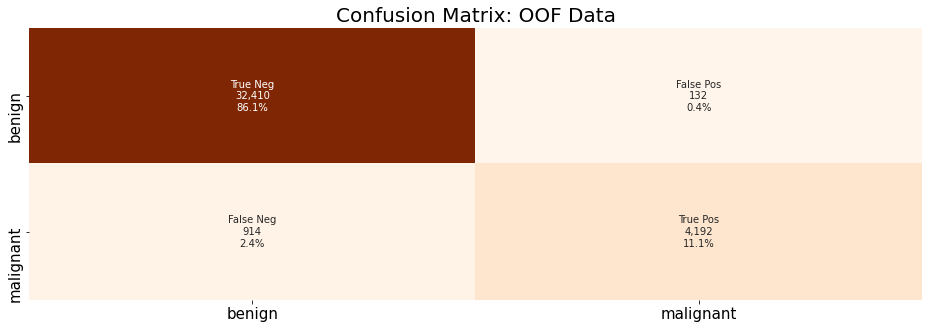

In [28]:
# Make OOF Binary
oof.loc[oof.oof >= 0.5, 'oof'] = 1
oof.loc[oof.oof < 0.5, 'oof'] = 0

# Create Confusion Matrix
cf_matrix = confusion_matrix(train_df['target'], oof)

# Pretty CM:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{:,}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.1%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(16, 5))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges',xticklabels=['benign', 'malignant'], 
            yticklabels=['benign', 'malignant'], cbar=False)

matplotlib.rcParams.update({'font.size': 15})
plt.tick_params(axis='both', labelsize=15)
plt.title('Confusion Matrix: OOF Data', fontsize=20);

# References:
* [Melanoma. Pytorch starter. EfficientNet](https://www.kaggle.com/nroman/melanoma-pytorch-starter-efficientnet/output)
* [melanoma external malignant 256](https://www.kaggle.com/nroman/melanoma-external-malignant-256)